# Data Cleaning for Austin Bikeshare Data


In [3]:
## Change to False if you do not want to download any necessary files 
download_files = False 

## Libraries for Data Processing
import numpy as np
import pandas as pd
import datetime as dt 

## code to read in data (path may need to be adjusted based on working directory)
station_data = pd.read_csv("../data/austin_bikeshare_stations.csv")
trips_data = pd.read_csv("../data/austin_bikeshare_trips.csv")

## Exploring and Understanding the Dataset
Using pandas built-in functions such as `.describe()`, `.isna()` and `.nunique()`, this section will inspect each variable from both the stations and trips dataset and check for unordinary statistics and invalid data to prepare for data cleaning

### trips_data

In [4]:
trips_data.describe() 

,bikeid,duration_minutes,end_station_id,month,start_station_id,trip_id,year
count,648508.000000,649231.000000,629389.000000,618479.000000,630190.000000,6.492310e+05,618479.000000
mean,471.615214,29.127506,2582.470617,5.887185,2584.238288,5.384945e+09,2015.340026
std,323.588379,87.278642,319.898534,3.206358,320.840964,4.925349e+09,1.019771
min,3.000000,0.000000,1001.000000,1.000000,1001.000000,8.269930e+06,2013.000000
25%,208.000000,8.000000,2499.000000,3.000000,2501.000000,1.274709e+07,2014.000000
50%,417.000000,15.000000,2548.000000,5.000000,2549.000000,9.900028e+09,2015.000000
75%,745.000000,28.000000,2571.000000,9.000000,2571.000000,9.900190e+09,2016.000000
max,5089.000000,21296.000000,3687.000000,12.000000,3687.000000,9.900353e+09,2017.000000


<Axes: >

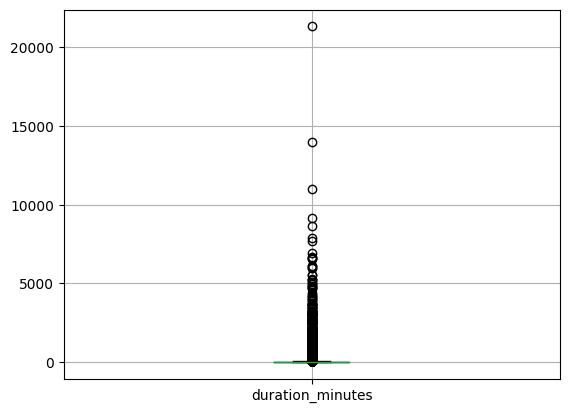

In [5]:
trips_data[['duration_minutes']].boxplot()

In [6]:
trips_data.nunique() 

bikeid                   410
checkout_time          65663
duration_minutes        1417
end_station_id            71
end_station_name          92
month                     12
start_station_id          71
start_station_name        90
start_time            357010
subscriber_type           52
trip_id               649231
year                       5
dtype: int64

In [7]:
trips_data.isna().sum()

bikeid                  723
checkout_time             0
duration_minutes          0
end_station_id        19842
end_station_name          0
month                 30752
start_station_id      19041
start_station_name        0
start_time                0
subscriber_type        2077
trip_id                   0
year                  30752
dtype: int64

#### Findings
- From the first table, range of month and year are reasonable but the range of `duration_minutes` stands out. `duration_minutes` has mean of 29.13 where 75% quartile is 28 but maximum is 21296. Pltting a boxplot shows clearly that the data is greatly skewed and has large outliers

- 'id' variables are for identification purposes hence the value and distribution provides little information. Looking at the unique values of each variable shows the number of `end_station_id`s are different from the `end_station_name` (same as for `start_station_id` and `start_station_name`).

- Looking further at the missing values for each variable, we see that the mismatch in number of names and id might have to do with NA values.

- `month` and `year` also have missing values, which can be extracted from `start_time` (has both date and time)

### Station_data

In [8]:
station_data.isna().sum() ## there are no missing values 

latitude      0
location      0
longitude     0
name          0
station_id    0
status        0
dtype: int64

In [9]:
station_data.nunique()

latitude      72
location      72
longitude     72
name          72
station_id    72
status         4
dtype: int64

#### Findings
- `station_data` seems relatively clean as there are no missing values.
- There are 72 unique station names each with a unique location which is reasonable.

## Validating data and Cleaning `trips_data`
1. missing `month` and `year` values will be filled using `start_time`
2. rows with invalid stations based on `station_data` station `names` will be removed
3. `start_station_id` and `end_station_id` will be filled by merging data from `station_data`
4. remaing rows with na will be dropped as they will be assumed as invalid data

In [10]:
## convert start_time data in trips_data to a Python datetime object
def str_to_datetime(s):
  '''
  takes a string of input "DD/MM/YYYY  HH:MM:SS" (note the double space)
  returns a datetime object with attributes .year , .day , .month , .hour etc 
  '''
  YY, MM, DD, = int(s[:-9].split("-")[0]), int(s[:-9].split("-")[1]), int(s[:-9].split("-")[2])
  hh, mm, ss = int(s[-8:].split(":")[0]), int(s[-8:].split(":")[1]), int(s[-8:].split(":")[2])
  return dt.datetime(YY, MM, DD, hour = hh, minute= mm, second= ss)

trips_data['start_datetime'] = list(map(lambda x: str_to_datetime(x), trips_data['start_time']))
trips_data = trips_data.drop(['start_time'], axis = 1)

## create a column for starting hour 
trips_data['start_hour'] = list(map(lambda x: x.hour, trips_data['start_datetime']))

## modifying the year and month columns to fill up the empty values
trips_data['year'] = list(map(lambda x: x.year, trips_data['start_datetime']))
trips_data['month'] = list(map(lambda x: x.month, trips_data['start_datetime']))

In [11]:
## dictionary of mistyped words based on observation
mistyped = {'ACC - West & 12th': 'ACC - West & 12th Street', 
            'Convention Center/ 3rd & Trinity': 'Convention Center / 3rd & Trinity', 
            'East 11th Street at Victory Grill': 'East 11th St. at Victory Grill', 
            'Red River @ LBJ Library': 'Red River & LBJ Library',
            'Main Office': 'OFFICE/Main/Shop/Repair',
            'Shop': 'OFFICE/Main/Shop/Repair', 
            'Main Shop': 'OFFICE/Main/Shop/Repair',
            'Repair Shop': 'OFFICE/Main/Shop/Repair',
            'Re-branding': 'OFFICE/Main/Shop/Repair',
            'Customer Service': 'OFFICE/Main/Shop/Repair'} 
          
## use a set for fast lookup
station_name_set = set(station_data['name'])

trips_data['start_station_name'] = list(map(lambda x: x if x not in mistyped else mistyped[x], trips_data['start_station_name']))
trips_data['end_station_name'] = list(map(lambda x: x if x not in mistyped else mistyped[x], trips_data['end_station_name']))

invalid_bool = list(map(lambda idx: (trips_data['start_station_name'][idx] not in station_name_set) \
                                    or (trips_data['end_station_name'][idx] not in station_name_set), range(len(trips_data)))) 
                                    # not required to check if station names are NA since we know that no 'NA' values exist
valid_bool = list(map(lambda x: not x, invalid_bool))

invalid_stations_data = trips_data[invalid_bool] #24030 rows, this contains some stations that do not exist as well as 'Stolen' and 'Missing' bikes
trips_data = trips_data[valid_bool] #625201 rows

In [12]:
## left join station data id to trips data according to starting station
trips_data = trips_data.merge(station_data[['name','station_id']],left_on='start_station_name', right_on='name', how='left')
trips_data = trips_data.drop(['name','start_station_id'], axis=1) # drop the 'start_station_id' column from trips_data
trips_data = trips_data.rename({'station_id':'start_station_id'}, axis = 1)
## left join station data to trips data according to end station
trips_data = trips_data.merge(station_data[['name','station_id']],left_on='end_station_name', right_on='name', how='left')
trips_data = trips_data.drop(['name','end_station_id'], axis=1) # drop the 'end_station_id' column from trips_data
trips_data = trips_data.rename({'station_id':'end_station_id'}, axis = 1)

In [13]:
trips_data = trips_data.dropna()

In [14]:
trips_data.isna().sum()

bikeid                0
checkout_time         0
duration_minutes      0
end_station_name      0
month                 0
start_station_name    0
subscriber_type       0
trip_id               0
year                  0
start_datetime        0
start_hour            0
start_station_id      0
end_station_id        0
dtype: int64

Through this section we have cleaned and validated the data and removed all missing values.

## Creating new variables
This is to help analysis and visualisation of the data



### `trips_data` making use of Python datetime object fuctions
1. Time categories `parts_of_day` on a day based on weather forecast categorisations (can be found here: https://wgntv.com/weather/how-do-you-define-daytime-and-evening-times-in-a-weather-forecast/) 
2. Day categories, numerically `day` starting from 0-6 (Monday-Sunday) and as a String `type_of_day` which will be 'Weekday' or 'Weekend'

In [15]:
def hh_to_category(n):
  '''
  takes in an integer n where 1 <= n <= 24
  returns a category (string) describing the part of the day it belongs to 
  '''
  if n < 3:
    return "midnight"
  elif n < 6:
    return "pre-dawn"
  elif n < 9:
    return 'early morning'
  elif n < 12:
    return 'late morning'
  elif n < 15:
    return 'early afternoon'
  elif n < 18:
    return 'late afternoon'
  elif n < 21:
    return 'evening'
  elif n <= 24:
    return 'night'

grouped_time_in_a_day = list(map(lambda x: hh_to_category(x), trips_data['start_hour']))
trips_data['parts_of_day'] = grouped_time_in_a_day

In [16]:
trips_data['day'] = list(map(lambda x: x.weekday(), trips_data['start_datetime'])) ## 0 is Monday, 6 is Sunday
trips_data['type_of_day'] = list(map(lambda x: 'Weekday' if x<5 else 'Weekend', trips_data['day']))

In [17]:
trips_data

,bikeid,checkout_time,duration_minutes,end_station_name,month,start_station_name,subscriber_type,trip_id,year,start_datetime,start_hour,start_station_id,end_station_id,parts_of_day,day,type_of_day
0,8.0,19:12:00,41,Trinity & 6th Street,3,Waller & 6th St.,Walk Up,9900082882,2015,2015-03-19 19:12:00,19,2536,2565,evening,3,Weekday
1,141.0,2:06:04,6,South Congress & Academy,10,2nd & Congress,Local365,12617682,2016,2016-10-30 02:06:04,2,2494,2570,midnight,6,Weekend
2,578.0,16:28:27,13,Convention Center / 4th St. @ MetroRail,3,Bullock Museum @ Congress & MLK,Local365,9075366,2016,2016-03-11 16:28:27,16,2538,2498,late afternoon,4,Weekday
3,555.0,15:12:00,80,Toomey Rd @ South Lamar,11,Capitol Station / Congress & 11th,24-Hour Kiosk (Austin B-cycle),9900319298,2014,2014-11-23 15:12:00,15,2497,2712,late afternoon,6,Weekend
4,86.0,15:39:13,25,MoPac Pedestrian Bridge @ Veterans Drive,4,Rainey St @ Cummings,Walk Up,14468597,2017,2017-04-16 15:39:13,15,2707,3377,late afternoon,6,Weekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625196,52.0,0:12:00,90,Red River & 8th Street,7,East 6th & Pedernales St.,24-Hour Kiosk (Austin B-cycle),9900185926,2014,2014-07-06 00:12:00,0,2544,2571,midnight,6,Weekend
625197,104.0,17:20:44,53,City Hall / Lavaca & 2nd,2,6th & Congress,Walk Up,13649794,2017,2017-02-06 17:20:44,17,3619,2499,late afternoon,0,Weekday
625198,240.0,13:12:55,44,4th & Congress,11,4th & Congress,Walk Up,9900329990,2015,2015-11-18 13:12:55,13,2495,2495,early afternoon,2,Weekday
625199,421.0,14:45:34,106,2nd & Congress,5,2nd & Congress,Try Before You Buy Special,10219003,2016,2016-05-29 14:45:34,14,2494,2494,early afternoon,6,Weekend


## Downloading data

In [18]:
if download_files:
  trips_data.to_csv("/content/trips_data.csv")